Dataset: **Sleep-EDF Expanded**  
https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
# !pip install mne pyedflib seglearn tsfel tsfresh antropy plotly-resampler tsflex powershap --upgrade

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../../ML_tools/src/")

sys.path.append("../src/")

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly_resampler import FigureResampler

## Download the data

Commands to download and extract the data;
```sh
mkdir data
wget https://physionet.org/static/published-projects/sleep-edfx/sleep-edf-database-expanded-1.0.0.zip -P data
# Extrac all data
unzip data/sleep-edf-database-expanded-1.0.0.zip -d data
```

# Create dataloader

## Some EDF loading funcs

In [6]:
from data import load_signals, load_annotations, annotation_to_30s_labels

## Load some data

In [7]:
data_folder = "../../../../data/sleep/sleep-edf-database-expanded-1.0.0/"

os.listdir(data_folder)

['sleep-telemetry',
 'RECORDS-v1',
 'SHA256SUMS.txt',
 'SC-subjects.xls',
 'sleep-cassette',
 'ST-subjects.xls',
 'RECORDS']

In [8]:
os.listdir(data_folder + "sleep-telemetry")[:10]

['ST7111J0-PSG.edf',
 'ST7061J0-PSG.edf',
 'ST7051J0-PSG.edf',
 'ST7121JE-Hypnogram.edf',
 'ST7201J0-PSG.edf',
 'ST7241J0-PSG.edf',
 'ST7041J0-PSG.edf',
 'ST7132JR-Hypnogram.edf',
 'ST7022J0-PSG.edf',
 'ST7142JE-Hypnogram.edf']

In [9]:
len(os.listdir(data_folder + "sleep-telemetry"))

88

In [10]:
!du -hs ../../../../data/sleep/sleep-edf-database-expanded-1.0.0/sleep-telemetry

1.1G	../../../../data/sleep/sleep-edf-database-expanded-1.0.0/sleep-telemetry


=> In total 88 files (44 PSG files - 153 hypnogram files) => 1.1 GB

In [11]:
dfs = []
sub_folder = "sleep-telemetry"
sorted_files = sorted(os.listdir(data_folder + sub_folder))
psg_hypnogram_files = [(p, h) for p, h in zip(sorted_files[::2], sorted_files[1:][::2])]
df_files = pd.DataFrame(psg_hypnogram_files, columns=["psg_file", "label_file"])
df_files["subfolder"] = sub_folder
    
# Because for the SC study patients were monitored for 2 consecutive nights
df_files["patient_id"] = df_files.psg_file.apply(lambda f: f[:5])
df_files

,psg_file,label_file,subfolder,patient_id
0,ST7011J0-PSG.edf,ST7011JP-Hypnogram.edf,sleep-telemetry,ST701
1,ST7012J0-PSG.edf,ST7012JP-Hypnogram.edf,sleep-telemetry,ST701
2,ST7021J0-PSG.edf,ST7021JM-Hypnogram.edf,sleep-telemetry,ST702
3,ST7022J0-PSG.edf,ST7022JM-Hypnogram.edf,sleep-telemetry,ST702
4,ST7041J0-PSG.edf,ST7041JO-Hypnogram.edf,sleep-telemetry,ST704
5,ST7042J0-PSG.edf,ST7042JO-Hypnogram.edf,sleep-telemetry,ST704
6,ST7051J0-PSG.edf,ST7051JA-Hypnogram.edf,sleep-telemetry,ST705
7,ST7052J0-PSG.edf,ST7052JA-Hypnogram.edf,sleep-telemetry,ST705
8,ST7061J0-PSG.edf,ST7061JR-Hypnogram.edf,sleep-telemetry,ST706
9,ST7062J0-PSG.edf,ST7062JR-Hypnogram.edf,sleep-telemetry,ST706


In [12]:
df_files.patient_id.nunique()

22

In [13]:
df_files.psg_file.nunique()

44

=> psg file can be used as recordingid   
=> patient id can be used as patient id 

In [14]:
signal_dict = {}

for idx in range(len(df_files)):
    sig, freq = load_signals(
        data_folder + df_files.iloc[idx].subfolder + "/" + df_files.iloc[idx].psg_file,
        only_info=True,
    )
    for s, f in zip(sig, freq):
        if (s, f) in signal_dict.keys():
            signal_dict[(s, f)].append(idx)
        else:
            signal_dict[(s, f)] = [idx]

[(k, len(v)) for k, v in signal_dict.items()]


[(('EEG Fpz-Cz', 100), 44),
 (('EEG Pz-Oz', 100), 44),
 (('EOG horizontal', 100), 44),
 (('EMG submental', 100), 44),
 (('Marker', 10), 44)]

In [15]:
common_signals = [
    'EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal',  # All have the same sampling rate (100 Hz)
    'EMG submental',  # Also 100 Hz
]

In [16]:
data = load_signals(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
    retrieve_signals=common_signals,
)
annotations = load_annotations(
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].label_file,
    data_folder + df_files.iloc[0].subfolder + "/" + df_files.iloc[0].psg_file,
)


In [17]:
# Used for plotting
cats = [
    "Sleep stage ?",
    "Movement time",
    "Sleep stage W",
    "Sleep stage 1",
    "Sleep stage 2",
    "Sleep stage 3",
    "Sleep stage 4",
    "Sleep stage R",
][::-1]


# EDA + pipeline (for 1 patient)

In [18]:
idxs = [s.name for s in data]

fig = FigureResampler(
    make_subplots(
        rows=len(idxs) + 1,
        cols=1,
        shared_xaxes=True,
        subplot_titles=idxs + ["Hypnogram"],
        vertical_spacing=0.05,
    ),
    default_n_shown_samples=3_000,
)

for idx, s in enumerate(data, 1):
    fig.add_trace(
        go.Scattergl(
            x=[], y=[], name=s.name, line_width=1,
        ),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )

fig.add_trace(
    go.Scattergl(
        x=[], y=[], name="Hypnogram", line_width=1.5, line_shape="hv",
    ),
    hf_x=annotation_to_30s_labels(annotations).index,
    hf_y=annotation_to_30s_labels(annotations)["label"].astype("category"),
    row=len(idxs) + 1,
    col=1,
)

fig.update_layout(height=900)
fig.update_yaxes(categoryorder="array", categoryarray=cats)

fig.update_layout(
    legend_traceorder="normal",
    template="plotly_white",
    #     legend=dict(orientation="h", y=1.07, xanchor="right", x=1),
)

fig.show_dash(port=8043)

Dash app running on http://127.0.0.1:8043/


## Process the signals

In [19]:
## Processing
from scipy.signal import butter, lfilter

from tsflex.processing import SeriesPipeline, SeriesProcessor


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    y = lfilter(b, a, sig)
    return y

eeg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    lowcut=0.4,
    highcut=30,
    fs=100,
)

emg_bandpass = SeriesProcessor(
    function=butter_bandpass_filter,
    series_names=["EMG submental"],
    lowcut=0.5,
    highcut=10,
    fs=100,
)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_bandpass,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.4, 'highcut': 30, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	butter_bandpass_filter {'lowcut': 0.5, 'highcut': 10, 'fs': 100} :  ('EMG submental',)
]

In [20]:
%%time
data_processed = process_pipe.process(data, return_all_series=True)

CPU times: user 230 ms, sys: 37.1 ms, total: 267 ms
Wall time: 266 ms


In [21]:
for s in data_processed:
    idx = idxs.index(s.name.split("_")[-1]) + 1
    fig.add_trace(
        go.Scatter(x=[], y=[], name=s.name + " processed", line_width=1),
        hf_x=s.index,
        hf_y=s.values,
        row=idx,
        col=1,
    )
    
fig.show_dash(port=8043)

Dash app running on http://127.0.0.1:8043/


## Extract the features

In [22]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings


{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [23]:
import antropy as ant
import scipy.stats as ss
from yasa import bandpower

import scipy.stats as ss
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper


def wrapped_higuchi_fd(x):
    x = np.array(x, dtype="float64")
    return ant.higuchi_fd(x)


bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]


def wrapped_bandpowers(x, sf, bands):
    return bandpower(x, sf=sf, bands=bands).values[0][:-2]


time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=100, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal", "EMG submental"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    ["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
    windows=["30s", "60s", "120s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats])
# fc


In [24]:
import logging

from tsflex.features.logger import logger

logger.setLevel(level=logging.ERROR)

from tsflex.processing.logger import logger

logger.setLevel(level=logging.ERROR)


In [25]:
# %%time
feats = feature_collection.calculate(data_processed, return_df=True, show_progress=True)
feats

  0%|          | 0/261 [00:00<?, ?it/s]

,EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s,EEG Fpz-Cz__TotalAbsPow__w=2m_s=30s,EEG Fpz-Cz__TotalAbsPow__w=30s_s=30s,EEG Fpz-Cz__alpha__w=1m_s=30s,EEG Fpz-Cz__alpha__w=2m_s=30s,EEG Fpz-Cz__alpha__w=30s_s=30s,EEG Fpz-Cz__beta__w=1m_s=30s,EEG Fpz-Cz__beta__w=2m_s=30s,EEG Fpz-Cz__beta__w=30s_s=30s,EEG Fpz-Cz__binned_entropy_{'max_bins': 10}__w=1m_s=30s,...,EOG horizontal__skew__w=30s_s=30s,EOG horizontal__std__w=1m_s=30s,EOG horizontal__std__w=2m_s=30s,EOG horizontal__std__w=30s_s=30s,EOG horizontal__theta__w=1m_s=30s,EOG horizontal__theta__w=2m_s=30s,EOG horizontal__theta__w=30s_s=30s,EOG horizontal__wrapped_higuchi_fd__w=1m_s=30s,EOG horizontal__wrapped_higuchi_fd__w=2m_s=30s,EOG horizontal__wrapped_higuchi_fd__w=30s_s=30s
1994-07-12 23:00:30,NaN,NaN,0.000129,NaN,NaN,0.001455,NaN,NaN,0.00123,NaN,...,-16.375955,NaN,NaN,9.131014e+01,NaN,NaN,0.004138,NaN,NaN,1.668797
1994-07-12 23:01:00,59.160905,NaN,430.740613,0.047708,NaN,0.012491,0.139694,NaN,0.027748,0.148398,...,-0.420953,7.912056e+01,NaN,6.467190e+01,0.087044,NaN,0.027942,1.559840,NaN,1.490229
1994-07-12 23:01:30,275.008346,NaN,163.929489,0.023462,NaN,0.045098,0.029236,NaN,0.034775,1.077765,...,0.516501,6.126265e+01,NaN,5.764924e+01,0.066995,NaN,0.056915,1.478861,NaN,1.461830
1994-07-12 23:02:00,60.26556,59.483989,48.112712,0.123613,0.086158,0.140403,0.100283,0.111048,0.137473,0.969259,...,-0.474760,5.134973e+01,6.669676e+01,4.414832e+01,0.069228,0.072615,0.075371,1.463777,1.518748,1.467424
1994-07-12 23:02:30,62.164828,77.648944,69.751903,0.128999,0.095438,0.154207,0.09944,0.087943,0.081213,0.912503,...,0.941957,3.561747e+01,5.010879e+01,2.423127e+01,0.090551,0.076312,0.100799,1.524624,1.496532,1.598236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-07-13 08:56:00,0.0,0.0,0.0,0.000402,0.000226,0.000454,0.000322,0.000181,0.000364,1.930830,...,-0.011193,3.468444e-07,3.880236e-07,3.681260e-07,0.000564,0.000494,0.000852,1.001069,1.000867,1.000949
1994-07-13 08:56:30,0.0,0.0,0.0,0.00044,0.000209,0.000376,0.000352,0.000168,0.000301,1.959112,...,0.067448,3.664674e-07,3.795429e-07,3.233459e-07,0.000456,0.000392,0.000201,1.001320,1.001323,1.001806
1994-07-13 08:57:00,0.0,0.0,0.0,0.000271,0.000349,0.000168,0.000217,0.00028,0.000134,2.054787,...,-0.509429,3.599661e-07,3.578874e-07,3.518555e-07,0.000207,0.000367,0.000294,1.001208,1.001047,1.001589
1994-07-13 08:57:30,0.0,0.0,0.0,0.000188,0.000319,0.000236,0.000151,0.000256,0.000189,2.124022,...,0.659906,3.353580e-07,3.546282e-07,3.149321e-07,0.00054,0.000365,0.000613,1.001866,1.001306,1.002720


# Pipeline for all patients

In [26]:
from tqdm.auto import tqdm

df_feats = []
for sub_folder, psg_file, hypnogram_file in tqdm(zip(df_files.subfolder, df_files.psg_file, df_files.label_file)):
    file_folder = data_folder + sub_folder + "/"
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(
        data_processed, return_df=True, window_idx="begin"
    ).astype("float32")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name & folder
    df_feat["psg_file"] = psg_file
    df_feat["patient_id"] = psg_file[:5]
    # Collect the dataframes
    df_feats += [df_feat]

df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

0it [00:00, ?it/s]

In [27]:
df_feats.to_parquet("../features/sleep-edf__telemetry_features_ALL.parquet")

## Load data

In [28]:
df_feats = pd.read_parquet("../features/sleep-edf__telemetry_features_ALL.parquet")
df_feats.shape

(42839, 366)

In [29]:
df_feats["label"].value_counts()

Sleep stage 2    19851
Sleep stage R     8349
Sleep stage W     4488
Sleep stage 1     3653
Sleep stage 3     3398
Sleep stage 4     3017
Movement time       83
Name: label, dtype: int64

In [30]:
df_feats[~df_feats.psg_file.isin(df_files.psg_file.unique())].psg_file.nunique()

0

In [31]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 366 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to patient_id
dtypes: float32(363), object(3)
memory usage: 60.6+ MB


In [32]:
eeg_signals = [d.name for d in data_processed if "EEG" in d.name]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")
df_feats.shape

(42839, 396)

In [33]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [34]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
feats_30s = [f for f in df_feats.columns if "w=30s" in f]
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]
    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

(42839, 920)

In [35]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42839 entries, 1994-07-12 23:00:00 to 1994-09-16 07:44:00
Columns: 920 entries, EEG Fpz-Cz__TotalAbsPow__w=1m_s=30s to EEG Pz-Oz__delta/theta__w=30s_s=30s_shift=-1m
dtypes: float32(917), object(3)
memory usage: 151.2+ MB


In [36]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats = df_feats[df_feats["label"] != "Movement time"]
df_feats = df_feats[df_feats["label"] != "Sleep stage ?"]  # Label that is given when recording is done / end of the night

df_feats = df_feats[~df_feats["label"].isna()]

In [37]:
df_feats.shape

(42756, 920)

Matches with the samples from the paper

The trimmed wake value count now matches (roughly) the amount of the IITNet paper

## EDA on labels

<AxesSubplot:>

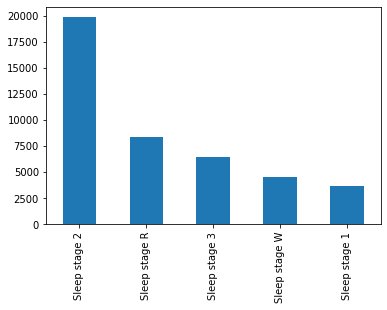

In [38]:
df_feats["label"].value_counts().plot(kind="bar")

In [39]:
df_feats["label"].value_counts()

Sleep stage 2    19851
Sleep stage R     8349
Sleep stage 3     6415
Sleep stage W     4488
Sleep stage 1     3653
Name: label, dtype: int64

=> There is quite some label imbalance

## EDA on features

In [40]:
skip_cols = ["psg_file", "label", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

In [41]:
import math

import matplotlib.pyplot as plt

plot_cols = [c for c in feat_cols if not "_shift=" in c]

# n_cols = 10
# n_rows = math.ceil(len(plot_cols) / n_cols)
# plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

# for idx, col in enumerate(plot_cols):
#     plt.subplot(n_rows, n_cols, idx + 1)
#     plt.boxplot(df_feats[col].dropna(), vert=True)
#     plt.xlabel(col)

# plt.tight_layout()
# plt.show()

# ML

In [42]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    cohen_kappa_score,
    log_loss,
)
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFpr, chi2

In [44]:
from ml_tools.visualizations.models_linear import plot_linear_classification_coefs
from ml_tools.visualizations.models import plot_learning_curve
from ml_tools.visualizations.evaluation import plot_confusion_matrix

## The simple, linear pipeline

In [45]:
### Create pipeline
pipe = Pipeline(
    [
        ("impute", SimpleImputer()),
        ("scale", QuantileTransformer()),
        ("selector", SelectFpr(chi2, alpha=1e-5)),
        (
            "linear_model",
            SGDClassifier(
                loss="log",
                average=True,
                class_weight="balanced",
                n_jobs=5,
                random_state=0,
            ),
        ),
    ]
)

### Grouped 10-fold results for all the data

In [46]:
# Total of 10 folds
gkfold = StratifiedGroupKFold(n_splits=10)
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=25,
    return_train_score=True,
    return_estimator=True,
)

In [47]:
print("10-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

10-FOLD: TRAIN
  MACRO F1:           0.8435
  Balanced accuracy:  0.8481
  Accuracy:           0.8723
  Log loss:           0.5986


In [48]:
print("10-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

10-FOLD: TEST
  MACRO F1:           0.7936
  Balanced accuracy:  0.8042
  Accuracy:           0.8311
  Log loss:           0.9901


In [49]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  901 features selected
fold 1  901 features selected
fold 2  898 features selected
fold 3  901 features selected
fold 4  901 features selected
fold 5  901 features selected
fold 6  901 features selected
fold 7  900 features selected
fold 8  899 features selected
fold 9  900 features selected

897 features in intersection
902 features in union


Text(0.5, 0, 'times selected')

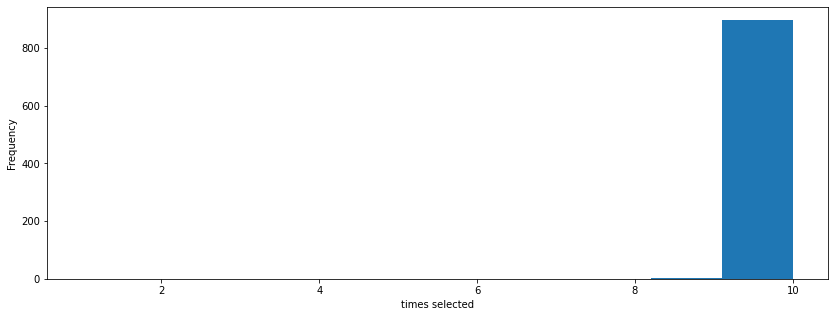

In [50]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [51]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7924403393355173
ACC: 0.8303396014594443
KAPPA: 0.7606419919118883
LOG LOSS: 0.9901801749377925


In [52]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.57      0.56      0.57      3708
Sleep stage 2       0.85      0.87      0.86     19468
Sleep stage 3       0.84      0.79      0.81      6843
Sleep stage R       0.86      0.89      0.88      8092
Sleep stage W       0.86      0.83      0.84      4645

     accuracy                           0.83     42756
    macro avg       0.80      0.79      0.79     42756
 weighted avg       0.83      0.83      0.83     42756



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

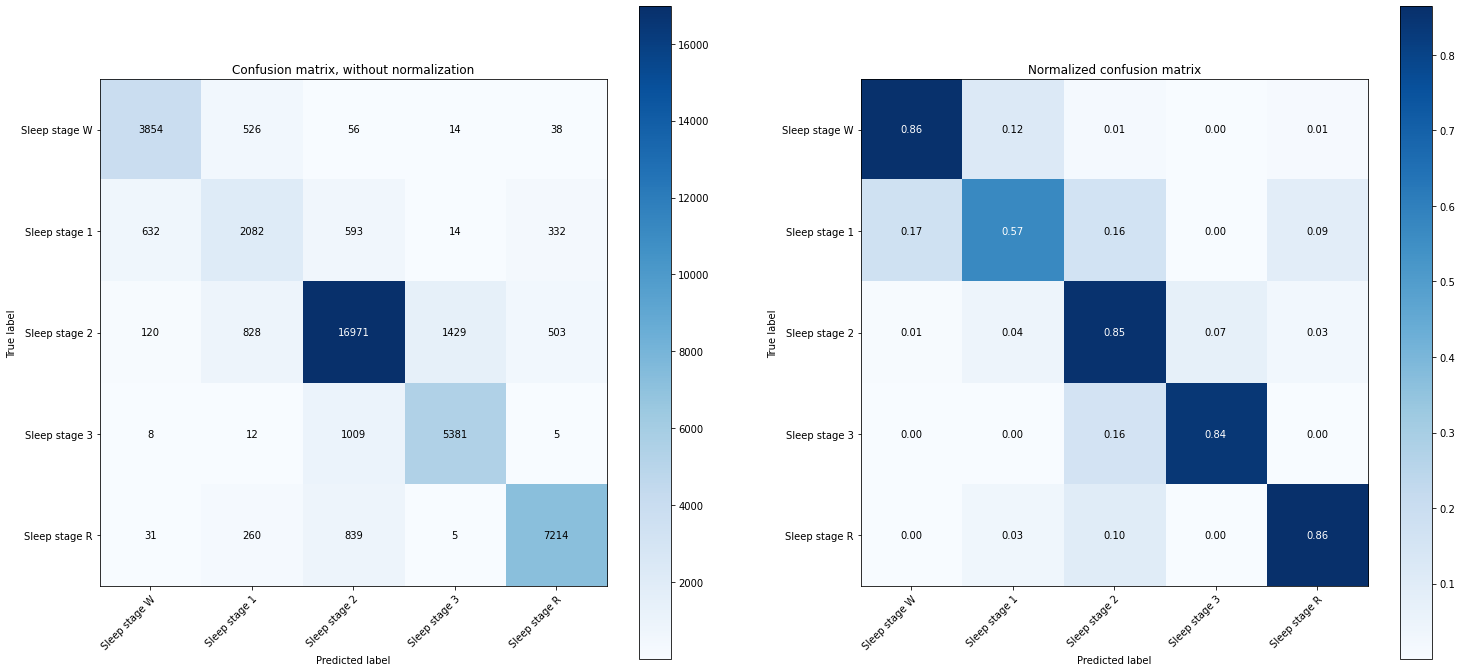

In [53]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

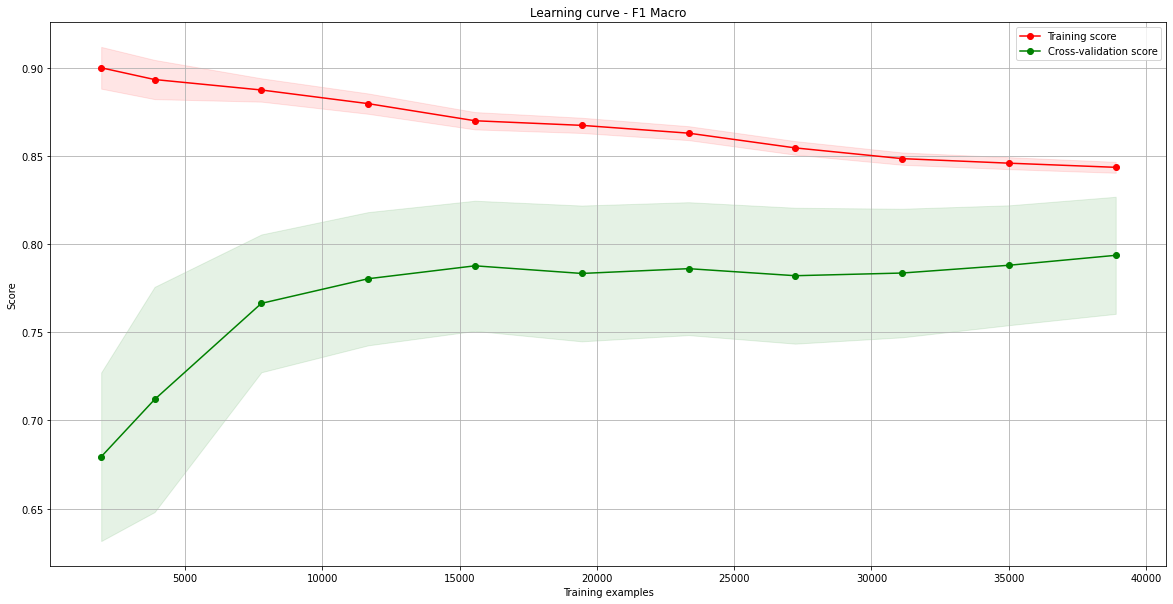

In [54]:
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)

_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)

### Grouped 22-fold for all the data

In [55]:
df_feats.patient_id.nunique()

22

In [56]:
# Total of 10 folds
gkfold = GroupKFold(n_splits=22)
cv = gkfold.split(df_feats, groups=df_feats.patient_id)

res = cross_validate(
    pipe,
    df_feats[feat_cols],
    df_feats["label"],
    scoring=["f1_macro", "balanced_accuracy", "accuracy", "neg_log_loss"],
    cv=cv,
    n_jobs=30,
    return_train_score=True,
    return_estimator=True,
)

In [57]:
print("22-FOLD: TRAIN")
print("  MACRO F1:          ", round(np.mean(res["train_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["train_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["train_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["train_neg_log_loss"]), 4))

22-FOLD: TRAIN
  MACRO F1:           0.8419
  Balanced accuracy:  0.8469
  Accuracy:           0.8709
  Log loss:           0.5945


In [58]:
print("22-FOLD: TEST")
print("  MACRO F1:          ", round(np.mean(res["test_f1_macro"]), 4))
print("  Balanced accuracy: ", round(np.mean(res["test_balanced_accuracy"]), 4))
print("  Accuracy:          ", round(np.mean(res["test_accuracy"]), 4))
print("  Log loss:          ", round(np.mean(-1 * res["test_neg_log_loss"]), 4))

22-FOLD: TEST
  MACRO F1:           0.7792
  Balanced accuracy:  0.8062
  Accuracy:           0.83
  Log loss:           0.9693


In [59]:
preds = []
preds_proba = []
y_trues = []
selected_feats = []
cv = gkfold.split(df_feats, df_feats["label"], groups=df_feats.patient_id)
for fold_ix, (train_idx, test_idx) in enumerate(cv):
    X_train = df_feats[feat_cols].iloc[train_idx]
    y_train = df_feats["label"].iloc[train_idx]
    X_test = df_feats[feat_cols].iloc[test_idx]
    y_test = df_feats["label"].iloc[test_idx]
    
    estimator = res["estimator"][fold_ix]
    preds += [estimator.predict(X_test)]
    preds_proba += [estimator.predict_proba(X_test)]
    y_trues += [y_test]
    selected_feats += [np.array(feat_cols)[estimator["selector"].get_support()]]

preds = np.hstack(preds)
y_trues = np.hstack(y_trues)
preds_proba = np.vstack(preds_proba)

917 features in total
fold 0  902 features selected
fold 1  902 features selected
fold 2  900 features selected
fold 3  901 features selected
fold 4  902 features selected
fold 5  901 features selected
fold 6  901 features selected
fold 7  902 features selected
fold 8  901 features selected
fold 9  901 features selected
fold 10  900 features selected
fold 11  901 features selected
fold 12  901 features selected
fold 13  901 features selected
fold 14  901 features selected
fold 15  901 features selected
fold 16  900 features selected
fold 17  898 features selected
fold 18  901 features selected
fold 19  901 features selected
fold 20  901 features selected
fold 21  901 features selected

898 features in intersection
902 features in union


Text(0.5, 0, 'times selected')

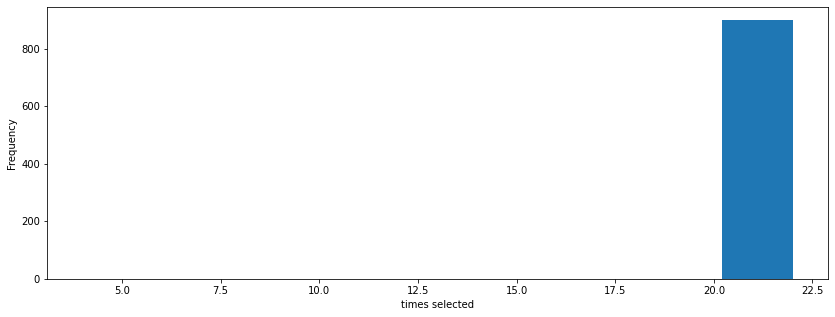

In [60]:
print(f"{len(feat_cols)} features in total")

selection_df = pd.DataFrame(data=set.union(*map(set, selected_feats)), columns=["feature"])
selection_df["times_selected"] = 0

for fold, feats in enumerate(selected_feats):
    print(f"fold {fold}  {len(feats)} features selected")
    selection_df.loc[selection_df.feature.isin(feats), "times_selected"] += 1

print()
print(f"{len(set.intersection(*map(set, selected_feats)))} features in intersection")
print(f"{len(set.union(*map(set, selected_feats)))} features in union")

ax = selection_df["times_selected"].plot(kind="hist", bins=10, figsize=(14,5))
plt.xlabel("times selected")

In [61]:
print("F1:", f1_score(preds, y_trues, average="macro"))
print("ACC:", accuracy_score(preds, y_trues))
print("KAPPA:", cohen_kappa_score(preds, y_trues))
print("LOG LOSS:", log_loss(y_trues, preds_proba))

F1: 0.7922472754951763
ACC: 0.829988773505473
KAPPA: 0.7602453653184077
LOG LOSS: 0.9705850289258298


In [62]:
print(classification_report(preds, y_trues))

               precision    recall  f1-score   support

Sleep stage 1       0.57      0.56      0.57      3743
Sleep stage 2       0.85      0.87      0.86     19424
Sleep stage 3       0.84      0.79      0.81      6827
Sleep stage R       0.87      0.89      0.88      8145
Sleep stage W       0.85      0.83      0.84      4617

     accuracy                           0.83     42756
    macro avg       0.80      0.79      0.79     42756
 weighted avg       0.83      0.83      0.83     42756



<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

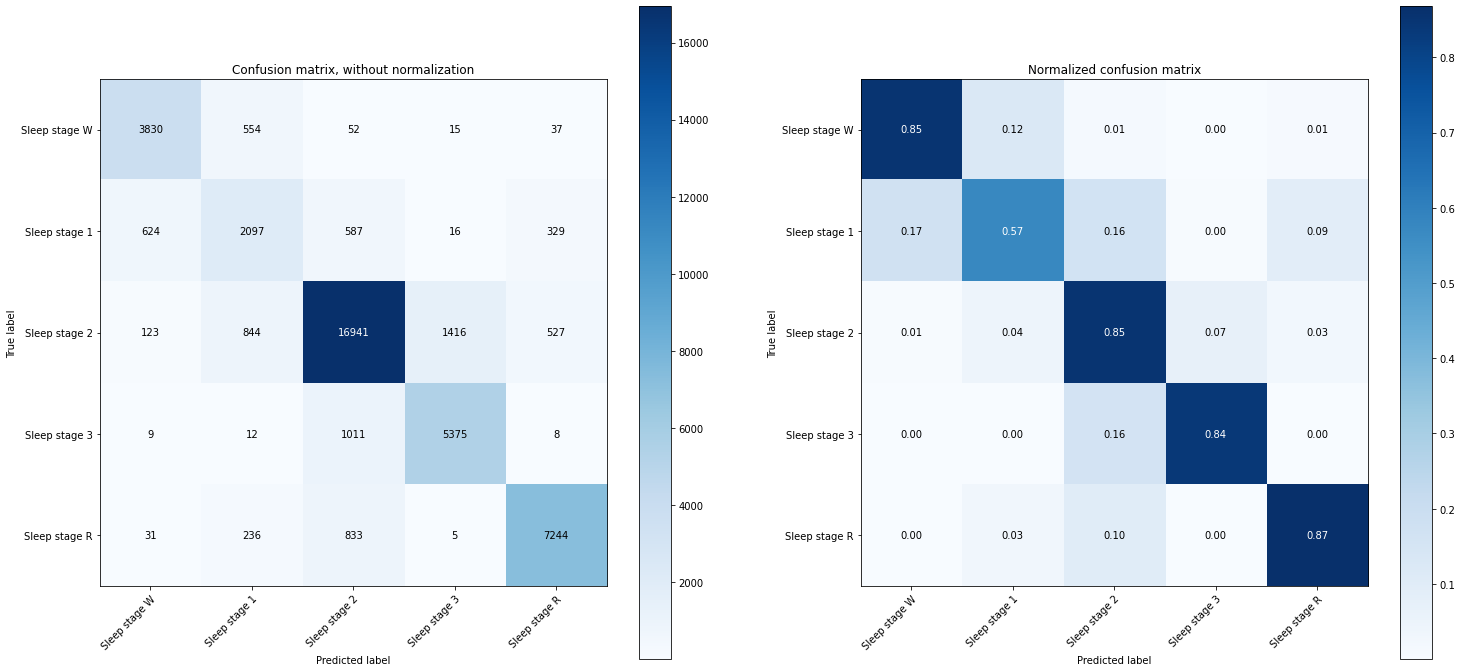

In [63]:
classes = [
    'Sleep stage W',
    'Sleep stage 1',
    'Sleep stage 2',
    'Sleep stage 3',
    'Sleep stage R'
]

plt.figure(figsize=(25,12))
ax = plt.subplot(1,2,1)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=False, ax=ax)
ax = plt.subplot(1,2,2)
plot_confusion_matrix(y_pred=preds, y_true=y_trues, classes=classes, normalize=True, ax=ax)

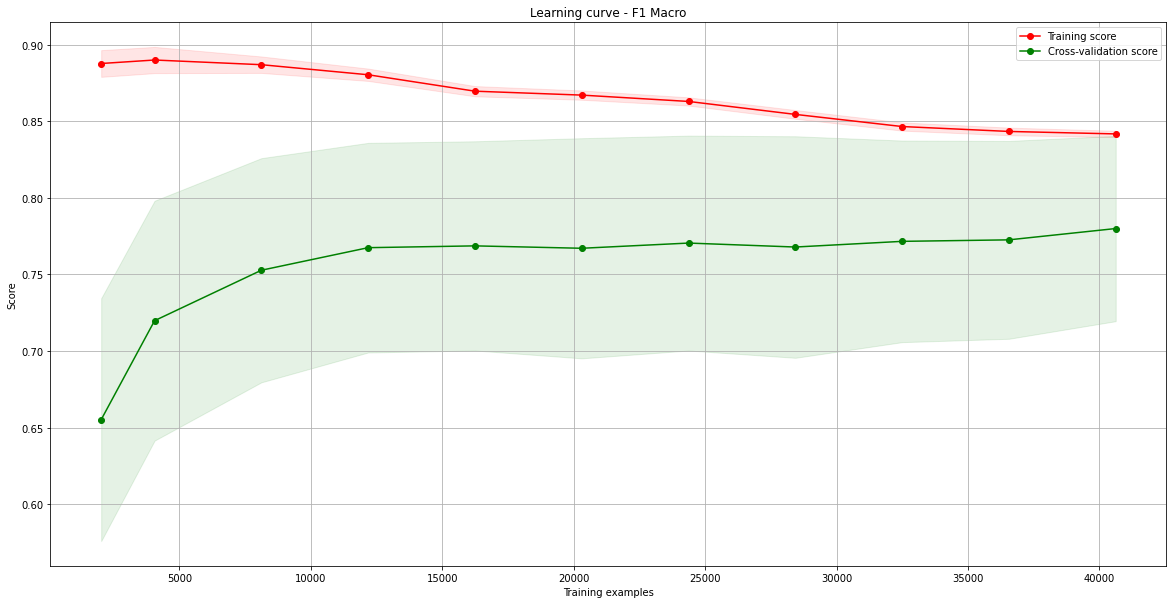

In [64]:
cv = gkfold.split(df_feats, groups=df_feats.patient_id)

_ = plot_learning_curve(
    pipe,
    title="Learning curve - F1 Macro",
    X=df_feats[feat_cols],
    y=df_feats["label"],
    cv=cv,
    scoring="f1_macro",
    n_jobs=25,
    train_sizes=[0.05] + list(np.linspace(0.1,1,10))
)